In [860]:
# 考虑三维: e_2/e_1 alpha lambda

from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import random


In [861]:
# Function to generate Cobb-Douglas utility functions
def Function(xs, alpha):
    res = 1.0
    for x in xs:
        res *= x**alpha
        alpha = 1.0-alpha
    return res

const__function = lambda xs: Function(xs, 0.5)

def generate_cobb_douglas_utility_function(alpha):
    return lambda xs, Alpha = alpha: Function(xs, Alpha)

def generate_functions(Number = 2, Type = 0, Alpha = 0.25):
    res = []
    res.append(const__function)
    if Type == 1:
        for whatever in np.arange(1, Number):
            alpha = random.random()
            res.append(generate_cobb_douglas_utility_function(alpha))
    else:
        res.append(generate_cobb_douglas_utility_function(Alpha))
    return res

def generate_goods(Number = 2, Type = 0, ratio = 1, total = 3.0):
    res = []
    res.append(total/(1+ratio))
    if Type == 1:
        for whatever in np.arange(1, Number):
            alpha = random.random()
            res.append(alpha)
    else:
        res.append(total-total/(1+ratio))
    return res

def generate_lambda(Number = 2, Type = 0, lambda1 = 0.5):
    res = []
    if Type == 1:
        tmp = []
        sum = 0
        for whatever in np.arange(0, Number):
            alpha = random.random()
            tmp.append(alpha)
            sum += alpha
        for alpha in tmp:
            res.append(alpha/sum)
    else:
        return [lambda1, 1.0-lambda1]
    return res

In [862]:
# Function to allocate goods and maximize utility
def maximize_utility(N, M, L, QUES, functions, lambdas, goods):
    # Define objective function to maximize
    def get_vector(xs, x, p):
        tmp = []
        for i in np.arange(0, L):
            tmp.append(xs[M*N+x*M*L+p*L+i])
        return tmp
     
    def get_max_good(xs, x, j):
        res = 0
        for i in np.arange(0, L):
            res= max(res, xs[M*N+x*M*L+i*L+j])
        return res
    def get_value(xs, x, y):
        res = 0
        for j in np.arange(0, M):
            tmp = get_vector(xs, y, j)
            res += xs[y*M+j] * functions[x](tmp)
        return res
    def objective(xs):
        sum = 0
        for i in np.arange(0, N):
            sum -= lambdas[i] * get_value(xs, i, i)
        return sum
    cons = []

    # Define constraint function: total goods should not exceed available goods
    def goods_constraint(xs, k, goods):
        res = -goods[k]
        for i in np.arange(0, N):
            res += get_max_good(xs, i, k)
        return res
    
    def solve_constraint(goods):
        for j in np.arange(0, L):
            cons.append({'type': 'eq', 'fun': lambda xs, idx = j: goods_constraint(xs, k = idx, goods = goods)})
    
    def add_constraint1():
        for i in np.arange(0, N):
            for j in np.arange(0, N):
                if i != j:
                    cons.append({'type': 'ineq', 'fun': lambda xs, idx = i, idy = j: get_value(xs, x = idx, y = idx) - get_value(xs, x = idx, y = idy)})
    def add_constraint2():
        def sum_x(xs, x):
            res = 0
            for i in np.arange(0, M):
                res += xs[M * x + i]
            return res
        for i in np.arange(0, N):
            cons.append({'type': 'eq', 'fun': lambda xs, idx = i: sum_x(xs, x = idx) - 1})
    def add_constraint3():
        for i in np.arange(0, N):
            cons.append({'type': 'eq', 'fun': lambda xs, ID = M*i: xs[ID] - 1})
            for p in np.arange(1, M):
                print(M*i+p)
                cons.append({'type': 'eq', 'fun': lambda xs, ID = M*i+p: xs[ID]})
    # Bounds: x >= 0
    bounds = [(0, None)] * ((N * M) + (N * M * L))
    x0 = [1.0, 0.0] * ((N * M) + (N * M * L))
    
    # Constraints
    solve_constraint(goods)
    if QUES == 2:
        add_constraint1()
    if QUES == 3:
        add_constraint2()
    else:
        add_constraint3()

    # print(cons)
    # Perform optimization
    res = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=cons)

    # Return optimal allocation and utility
    return res.x, -res.fun

In [863]:
#TO modify alpha lambda e1/e2的修改 生成数据集
# Define the range of alpha values
def solve(T = 1, N =2, M = 2, L = 2, LIST_ALPHA = 0, LIST_LAMBDAS = 0, LIST_GOODS = 0, TYPE = 0, QUES = 1, ALPHA = 0.25, LAMBDA = 0.5, RATIO = 1, TOTAL = 3):
    if(TYPE == 0):
        if LIST_ALPHA == 1:
            start_alpha = 0.01
            end_alpha = 0.99
            num_alphas = 99
            alphas = np.linspace(start_alpha, end_alpha, num_alphas)
            all_functions = [generate_functions(Number=N, Type=TYPE, Alpha=alpha) for alpha in alphas]
        else:
            alphas = [ALPHA]
            all_functions = [generate_functions(Number=N, Type=TYPE, Alpha=ALPHA)]
        if LIST_LAMBDAS == 1:
            start_lambda = 0.01
            end_lambda = 0.99
            num_lambda = 99
            lambdas = np.linspace(start_lambda, end_lambda, num_lambda)
            all_lambdas = [generate_lambda(Number=N, Type=TYPE, lambda1=lambda1) for lambda1 in lambdas]
        else:
            all_lambdas = [generate_lambda(Number=N, Type=TYPE, lambda1=LAMBDA)]
        if LIST_GOODS == 1:
            start_ratio = 0.01
            end_ratio = 0.99
            num_ratio = 99
            ratios = np.linspace(start_ratio, end_ratio, num_ratio)
            all_goods = [generate_goods(Number=N, Type=TYPE, ratio=ratio) for ratio in ratios]
        else:
            all_goods = [generate_goods(Number=N, Type=TYPE, ratio=RATIO, total=TOTAL)]
    else:
        all_functions = [generate_functions(Number=N, Type=TYPE, Alpha=ALPHA)]
        all_lambdas = [generate_lambda(Number=N, Type=TYPE, lambda1=LAMBDA)]
        all_goods = [generate_goods(Number=N, Type=TYPE, ratio= RATIO, total=TOTAL)]
    def calc(functions, lambdas, goods):
        optimal_allocation, max_utility = maximize_utility(N, M, L, QUES, functions, lambdas, goods)
        return optimal_allocation, max_utility
    optimal_allocations = []
    max_utilities = []
    for functions in all_functions:
        for lambdas in all_lambdas:
            for goods in all_goods:
                optimal_allocation, max_utility = calc(functions, lambdas, goods)
                optimal_allocations.append(optimal_allocation)
                max_utilities.append(max_utility)
    return alphas, all_lambdas, all_goods, optimal_allocations, max_utilities

In [864]:
alphas, all_lambdas, all_goods, optimal_allocations, max_utilities = solve(LIST_ALPHA = 1, QUES = 1)
print(alphas, all_lambdas, all_goods, optimal_allocations, max_utilities)
points_alphas_1 = list(zip(alphas, max_utilities))

1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
1
3
[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99] [[0.5, 0.5]] [[1.5, 1.5]] [array([1.00000000e+00, 2.45326947e-28, 1.00000000e+00, 6.93889390e-18,
   

In [865]:
points_alphas_2 = list(zip(alphas, max_utilities))

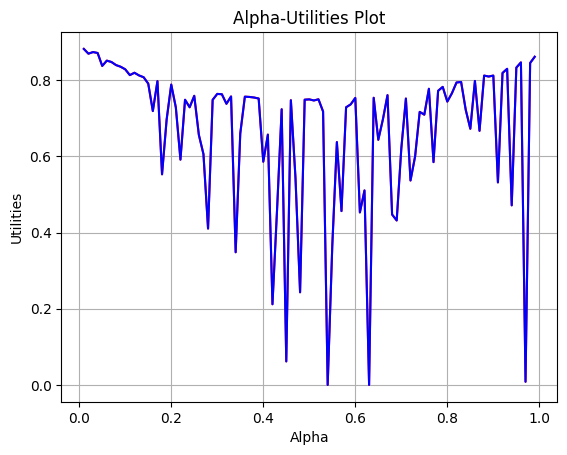

In [866]:
x_coords, y_coords = zip(*points_alphas_1)
plt.plot(x_coords, y_coords, color = 'red', label = 'Quetion1')
x_coords, y_coords = zip(*points_alphas_2)
plt.plot(x_coords, y_coords, color = 'blue', label = 'Quetion2')
plt.xlabel('Alpha')
plt.ylabel('Utilities')
plt.title('Alpha-Utilities Plot')
plt.grid(True)
plt.show()